In [14]:
from pandas import DataFrame
from pymongo import MongoClient
from pydash import group_by
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Table size

In [2]:
def get_GT_row_counts():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['files'].aggregate([
            {
                 '$match': {
                     'incomplete': {'$exists': False}
                 }
            },
            {
                '$unwind': {
                    'path': '$tables'
                }
            }, {
                '$addFields': {
                    'tables.rowCount': {
                        '$add': [
                            {
                                '$subtract': [
                                    '$tables.to', '$tables.from'
                                ]
                            }, 1
                        ]
                    }
                }
            }, {
                '$project': {
                    '_id': False,
                    'rowCount': '$tables.rowCount'
                }
            }
        ])

In [3]:
def get_GT_column_counts():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['files'].aggregate([
            {
                '$match': {
                    'incomplete': {
                        '$exists': False
                    }
                }
            }, {
                '$unwind': {
                    'path': '$tables'
                }
            }, {
                '$lookup': {
                    'from': 'lines', 
                    'let': {
                        'fileId': {
                            '$toString': '$_id'
                        }, 
                        'from': '$tables.from'
                    }, 
                    'pipeline': [
                        {
                            '$match': {
                                '$expr': {
                                    '$and': [
                                        {
                                            '$eq': [
                                                '$fileId', '$$fileId'
                                            ]
                                        }, {
                                            '$eq': [
                                                '$index', '$$from'
                                            ]
                                        }
                                    ]
                                }
                            }
                        }
                    ], 
                    'as': 'line'
                }
            }, {
                '$unwind': {
                    'path': '$line'
                }
            }, {
                '$project': {
                    '_id': False,
                    'colCount': {
                        '$size': '$line.post-processed'
                    }
                }
            }
        ])

In [4]:
# https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_size(width=422.52348, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

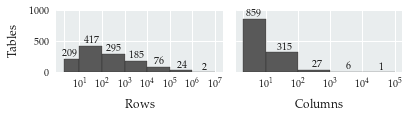

In [17]:
df = DataFrame({
    'rowCounts': [rowCount['rowCount'] for rowCount in get_GT_row_counts()],
    'columnCounts': [columnCount['colCount'] for columnCount in get_GT_column_counts()]
})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=set_size(subplots=(1, 2)), sharey=True)

# row count
ax = df['rowCounts'].plot(
    kind='hist', 
    by=['rowCounts'], 
    bins=[2, 10, 100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000],
    rot=0,
    ax=axes[0],
    color=['#595959'],
    edgecolor='#1B1B1B'
)
ax.set_xscale('log')
ax.set(
    xlabel='Rows', 
    ylabel='Tables',
    ylim=(0, 1000),
    xticks=[2, 10, 100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000]
)

for p in ax.patches:
    ax.annotate(
        round(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',                              
        va='center',                              
        xytext=(-5, 5),                               
        textcoords='offset points',
        fontsize=10
    )
    
# col count
ax = df['columnCounts'].plot(
    kind='hist', 
    by=['columnCounts'], 
    bins=[2, 10, 100, 1_000, 10_000, 100_000],
    rot=0,
    ax=axes[1],
    color=['#595959'],
    edgecolor='#1B1B1B'
)
ax.set_xscale('log')
ax.set(
    xlabel='Columns', 
    ylim=(0, 1000),
    xticks=[2, 10, 100, 1_000, 10_000, 100_000]
)

for p in ax.patches:
    ax.annotate(
        round(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',                              
        va='center',                              
        xytext=(-5, 5),                               
        textcoords='offset points',
        fontsize=10
    )
plt.tight_layout()
ax.get_figure().savefig('ground-truth-table-size')

# Header rows

In [6]:
with MongoClient() as mongo:
    db = mongo['master']
    result = [*db['files'].aggregate([
        {
            '$match': {
                'incomplete': {
                    '$exists': False
                }
            }
        }, {
            '$unwind': {
                'path': '$tables'
            }
        }, {
            '$lookup': {
                'from': 'lines', 
                'let': {
                    'fileId': {
                        '$toString': '$_id'
                    }, 
                    'fromIndex': '$tables.from', 
                    'toIndex': '$tables.to'
                }, 
                'pipeline': [
                    {
                        '$match': {
                            '$expr': {
                                '$and': [
                                    {
                                        '$eq': [
                                            '$fileId', '$$fileId'
                                        ]
                                    }, {
                                        '$gte': [
                                            '$index', '$$fromIndex'
                                        ]
                                    }, {
                                        '$lte': [
                                            '$index', '$$toIndex'
                                        ]
                                    }, {
                                        '$eq': [
                                            '$rowType', 'header'
                                        ]
                                    }
                                ]
                            }
                        }
                    }
                ], 
                'as': 'line'
            }
        }, {
            '$project': {
                '_id': False, 
                'headerRows': {
                    '$size': '$line'
                }
            }
        }, {
            '$group': {
                '_id': '$headerRows', 
                'count': {
                    '$sum': 1
                }
            }
        }
    ])]
result

[{'_id': 1, 'count': 747},
 {'_id': 0, 'count': 419},
 {'_id': 3, 'count': 3},
 {'_id': 2, 'count': 38},
 {'_id': 4, 'count': 1}]

# Dialect variety

In [7]:
with MongoClient() as mongo:
    db = mongo['master']
    result = [*db['files'].aggregate([
        {
            '$match': {
                'incomplete': {
                    '$exists': False
                }
            }
        }, {
            '$unwind': {
                'path': '$tables'
            }
        }, {
            '$match': {
                'tables.type': 'character'
            }
        }, {
            '$lookup': {
                'from': 'lines', 
                'let': {
                    'fileId': {
                        '$toString': '$_id'
                    }, 
                    'fromIndex': '$tables.from', 
                    'toIndex': {
                        '$min': [
                            '$tables.to', {
                                '$add': [
                                    '$tables.from', 20
                                ]
                            }
                        ]
                    }
                }, 
                'pipeline': [
                    {
                        '$match': {
                            '$expr': {
                                '$and': [
                                    {
                                        '$eq': [
                                            '$fileId', '$$fileId'
                                        ]
                                    }, {
                                        '$gte': [
                                            '$index', '$$fromIndex'
                                        ]
                                    }, {
                                        '$lte': [
                                            '$index', '$$toIndex'
                                        ]
                                    }, {
                                        '$eq': [
                                            {
                                                '$first': '$delimiter.sequence'
                                            }, ','
                                        ]
                                    }, {
                                        '$or': [
                                            {
                                                '$eq': [
                                                    {
                                                        '$size': '$quotation'
                                                    }, 0
                                                ]
                                            }, {
                                                '$eq': [
                                                    {
                                                        '$first': '$quotation'
                                                    }, '\"'
                                                ]
                                            }, {
                                                '$eq': [
                                                    {
                                                        '$first': '$quotation'
                                                    }, '\"\"'
                                                ]
                                            }
                                        ]
                                    }
                                ]
                            }
                        }
                    }
                ], 
                'as': 'lines'
            }
        }, {
            '$project': {
                'isRFC': {
                    '$gt': [
                        {
                            '$size': '$lines'
                        }, 0
                    ]
                }
            }
        }, {
            '$group': {
                '_id': '$isRFC', 
                'count': {
                    '$sum': 1
                }
            }
        }
    ])]
result

[{'_id': False, 'count': 528}, {'_id': True, 'count': 490}]

In [8]:
with MongoClient() as mongo:
    db = mongo['master']
    result = [*db['files'].aggregate([
            {
                '$match': {
                    'incomplete': {
                        '$exists': False
                    }
                }
            }, {
                '$unwind': {
                    'path': '$tables'
                }
            }, {
                '$match': {
                    'tables.type': 'character'
                }
            }, {
                '$lookup': {
                    'from': 'lines', 
                    'let': {
                        'fileId': {
                            '$toString': '$_id'
                        }, 
                        'fromIndex': '$tables.from', 
                        'toIndex': {
                            '$min': [
                                '$tables.to', {
                                    '$add': [
                                        '$tables.from', 20
                                    ]
                                }
                            ]
                        }
                    }, 
                    'pipeline': [
                        {
                            '$match': {
                                '$expr': {
                                    '$and': [
                                        {
                                            '$eq': [
                                                '$fileId', '$$fileId'
                                            ]
                                        }, {
                                            '$gte': [
                                                '$index', '$$fromIndex'
                                            ]
                                        }, {
                                            '$lte': [
                                                '$index', '$$toIndex'
                                            ]
                                        }, {
                                            '$or': [
                                                {
                                                    '$and': [
                                                        {
                                                            '$gt': [
                                                                {
                                                                    '$size': {
                                                                        '$filter': {
                                                                            'input': '$delimiter.sequence', 
                                                                            'as': 'd', 
                                                                            'cond': {
                                                                                '$gt': [
                                                                                    {
                                                                                        '$strLenCP': '$$d'
                                                                                    }, 1
                                                                                ]
                                                                            }
                                                                        }
                                                                    }
                                                                }, 0
                                                            ]
                                                        }, {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$delimiter.sequence'
                                                                }, '\t'
                                                            ]
                                                        }, {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$delimiter.sequence'
                                                                }, '\\t'
                                                            ]
                                                        },  {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$delimiter.sequence'
                                                                }, ', '
                                                            ]
                                                        }
                                                    ]
                                                }, {
                                                    '$and': [
                                                        {
                                                            '$gt': [
                                                                {
                                                                    '$size': {
                                                                        '$filter': {
                                                                            'input': '$quotation', 
                                                                            'as': 'q', 
                                                                            'cond': {
                                                                                '$gt': [
                                                                                    {
                                                                                        '$strLenCP': '$$q'
                                                                                    }, 1
                                                                                ]
                                                                            }
                                                                        }
                                                                    }
                                                                }, 0
                                                            ]
                                                        }, {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$quotation'
                                                                }, '\t'
                                                            ]
                                                        }, {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$quotation'
                                                                }, '\\t'
                                                            ]
                                                        }
                                                    ]
                                                }, {
                                                    '$and': [
                                                        {
                                                            '$gt': [
                                                                {
                                                                    '$size': {
                                                                        '$filter': {
                                                                            'input': '$escape', 
                                                                            'as': 'e', 
                                                                            'cond': {
                                                                                '$gt': [
                                                                                    {
                                                                                        '$strLenCP': '$$e'
                                                                                    }, 1
                                                                                ]
                                                                            }
                                                                        }
                                                                    }
                                                                }, 0
                                                            ]
                                                        }, {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$escape'
                                                                }, '\t'
                                                            ]
                                                        }, {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$escape'
                                                                }, '\\t'
                                                            ]
                                                        }
                                                    ]
                                                }
                                            ]
                                        }
                                    ]
                                }
                            }
                        }
                    ], 
                    'as': 'lines'
                }
            }, {
                '$project': {
                    'isMulti': {
                        '$gt': [
                            {
                                '$size': '$lines'
                            }, 0
                        ]
                    }
                }
            }, {
                '$group': {
                    '_id': '$isMulti', 
                    'count': {
                        '$sum': 1
                    }
                }
            }
        ])]
result

[{'_id': False, 'count': 1002}, {'_id': True, 'count': 16}]

In [9]:
with MongoClient() as mongo:
    db = mongo['master']
    result = [*db['files'].aggregate([
            {
                '$match': {
                    'incomplete': {
                        '$exists': False
                    }
                }
            }, {
                '$unwind': {
                    'path': '$tables'
                }
            }, {
                '$match': {
                    'tables.type': 'character'
                }
            }, {
                '$lookup': {
                    'from': 'lines', 
                    'let': {
                        'fileId': {
                            '$toString': '$_id'
                        }, 
                        'fromIndex': '$tables.from', 
                        'toIndex': {
                            '$min': [
                                '$tables.to', {
                                    '$add': [
                                        '$tables.from', 20
                                    ]
                                }
                            ]
                        }
                    }, 
                    'pipeline': [
                        {
                            '$match': {
                                '$expr': {
                                    '$and': [
                                        {
                                            '$eq': [
                                                '$fileId', '$$fileId'
                                            ]
                                        }, {
                                            '$gte': [
                                                '$index', '$$fromIndex'
                                            ]
                                        }, {
                                            '$lte': [
                                                '$index', '$$toIndex'
                                            ]
                                        }, {
                                            '$or': [
                                                {
                                                    '$and': [
                                                        {
                                                            '$gt': [
                                                                {
                                                                    '$size': {
                                                                        '$filter': {
                                                                            'input': '$delimiter.sequence', 
                                                                            'as': 'd', 
                                                                            'cond': {
                                                                                '$gt': [
                                                                                    {
                                                                                        '$strLenCP': '$$d'
                                                                                    }, 1
                                                                                ]
                                                                            }
                                                                        }
                                                                    }
                                                                }, 0
                                                            ]
                                                        }, {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$delimiter.sequence'
                                                                }, '\t'
                                                            ]
                                                        }, {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$delimiter.sequence'
                                                                }, '\\t'
                                                            ]
                                                        },  {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$delimiter.sequence'
                                                                }, ', '
                                                            ]
                                                        }
                                                    ]
                                                }, {
                                                    '$and': [
                                                        {
                                                            '$gt': [
                                                                {
                                                                    '$size': {
                                                                        '$filter': {
                                                                            'input': '$quotation', 
                                                                            'as': 'q', 
                                                                            'cond': {
                                                                                '$gt': [
                                                                                    {
                                                                                        '$strLenCP': '$$q'
                                                                                    }, 1
                                                                                ]
                                                                            }
                                                                        }
                                                                    }
                                                                }, 0
                                                            ]
                                                        }, {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$quotation'
                                                                }, '\t'
                                                            ]
                                                        }, {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$quotation'
                                                                }, '\\t'
                                                            ]
                                                        }
                                                    ]
                                                }, {
                                                    '$and': [
                                                        {
                                                            '$gt': [
                                                                {
                                                                    '$size': {
                                                                        '$filter': {
                                                                            'input': '$escape', 
                                                                            'as': 'e', 
                                                                            'cond': {
                                                                                '$gt': [
                                                                                    {
                                                                                        '$strLenCP': '$$e'
                                                                                    }, 1
                                                                                ]
                                                                            }
                                                                        }
                                                                    }
                                                                }, 0
                                                            ]
                                                        }, {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$escape'
                                                                }, '\t'
                                                            ]
                                                        }, {
                                                            '$ne': [
                                                                {
                                                                    '$first': '$escape'
                                                                }, '\\t'
                                                            ]
                                                        }
                                                    ]
                                                }
                                            ]
                                        }
                                    ]
                                }
                            }
                        }
                    ], 
                    'as': 'lines'
                }
            }, {
                '$addFields': {
                    'isMulti': {
                        '$gt': [
                            {
                                '$size': '$lines'
                            }, 0
                        ]
                    }
                }
            }, {
                '$match': {
                    'isMulti': True
                }
            }
        ])]
result

[{'_id': ObjectId('5fa1aa2a0c27781bd85559a8'),
  'tables': {'from': 1, 'to': 100, 'type': 'character'},
  'absolutePath': '/home/datasets/mendeley/d5z89nnyv6-1.zip/SampleCalculation/Output/MEAM/sepnHistogram.out',
  'source': 'mendeley',
  'hash': '0aebd6b22f28f97735c1b28a5996179e',
  'type': 'complex',
  'lineCount': 101,
  'parsing_instructions': {'character': 513, 'layout': 201},
  'lines': [{'_id': ObjectId('5fa1aa2a0c27781bd85559aa'),
    'delimiter': {'type': 'character', 'sequence': ['    ']},
    'escape': [],
    'quotation': [],
    'rowType': 'data',
    'raw': '   1.74687     0.00000    0.00003    0.00000\n',
    'index': 1,
    'fileId': '5fa1aa2a0c27781bd85559a8',
    'isPartOfTable': True,
    'skip': False,
    'parsed': ['1.74687', '0.00000', '0.00003', '0.00000'],
    'post-processed': ['1.74687', '0.00000', '0.00003', '0.00000']},
   {'_id': ObjectId('5fa1aa2a0c27781bd85559ab'),
    'delimiter': {'type': 'character', 'sequence': ['    ']},
    'escape': [],
    'quot

examples that use multi-char:
- multiple spaces
- multiple tabs
- wider spaces
- -->
- //

# Table type per file complexity

In [10]:
def get_table_type_count_per_file_type():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$match': {
                    'fileMetrics_incomplete': False, 
                    'parser': 'rfc4180'
                }
            }, {
                '$unwind': {
                    'path': '$tableMetrics_tables'
                }
            }, {
                '$group': {
                    '_id': {
                        'fileType': '$fileMetrics_fileType', 
                        'tableType': '$tableMetrics_tables.type'
                    }, 
                    'count': {
                        '$sum': 1
                    }
                }
            }
        ])

In [11]:
# https://stackoverflow.com/questions/16259923/how-can-i-escape-latex-special-characters-inside-django-templates
import re

def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

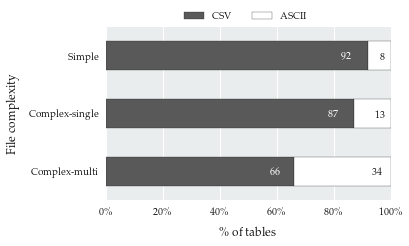

In [16]:
sort_dict = {'Simple': 0, 'Complex-single': 1, 'Complex-multi': 2}
data = [
    {
        **{
            k: tex_escape(v.replace('_', '-'))
            for k, v in group['_id'].items()
        },
        'count': group['count']        
    }
    for group in get_table_type_count_per_file_type()
]
data = [
    {
        **record,
        'count': 100 * record['count'] / sum(r['count'] for r in data if r['fileType'] == record['fileType'])
    }
    for record in data
]
df = DataFrame([
    {
        'fileType': k.capitalize(),
        'CSV': next(entry['count'] for entry in v if entry['tableType'] =='character'),
        'ASCII': next(entry['count'] for entry in v if entry['tableType'] =='layout')
    }
    for k, v in group_by(data, 'fileType').items()
]).sort_values(
    by=['fileType'], 
    key=lambda file_type: file_type.map(sort_dict),
    ascending=False
).set_index(
    'fileType'
)

ax = df.plot(
    kind='barh',
    stacked=True,
    color=['#595959', '#FFFFFF'],
    edgecolor='#1B1B1B'
)
ax.set(
    xlabel='\% of tables', 
    ylabel='File complexity',
    xlim=(0, 100)
)

for i_p, p in enumerate(ax.patches):        
    ax.annotate(
        round(p.get_width()), 
        (p.get_x() + p.get_width() * 0.95 - 1.5, p.get_y() + p.get_height() / 2), 
        verticalalignment='center_baseline', 
        horizontalalignment='right', 
        fontsize=10,
        color='#FFFFFF' if int(i_p / 3) == 0 else None
    )
ax.legend(loc='lower center', bbox_to_anchor=(0, 0.98, 0.98, 0), ncol=2)
ax.get_xaxis().set_major_formatter(mtick.PercentFormatter(xmax=100))

plt.tight_layout()
ax.get_figure().savefig('table-type-per-file-complexity')